In [12]:
from omegaconf import OmegaConf
import torchvision

from settings import *
from data import *
from model_visual import *

import PIL
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

In [2]:
args = OmegaConf.load(ROOT_DIR+'/configs/config.yaml')
device = torch.device("cpu")

In [3]:
image_model = ResNet50(args.image_model.hid_dim, args.data.n_classes, args.image_model.dropout).to(device)
file = torch.load(TRAINED_MODELS_DIR + '/image_model.pt', map_location=device)
image_model.load_state_dict(file['model'])

<All keys matched successfully>

In [4]:
print(image_model.model_wo_fc)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [5]:
cam_extractor = GradCAM(image_model, image_model.model_wo_fc[7])

In [6]:
test_dataset = MIMIC_CXR(REPORT_PREPROCESS_DIR+'/test_output.jsonl', IMG_DIR_TEST)

In [7]:
image, labels = test_dataset[0]
_, logits = image_model(image.unsqueeze(0).to(device))
probs = torch.sigmoid(logits.squeeze())
preds = torch.round(probs)
print(f'Labels      -> {labels}')
print(f'Predictions -> {preds}')

Labels      -> tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
Predictions -> tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       grad_fn=<RoundBackward0>)


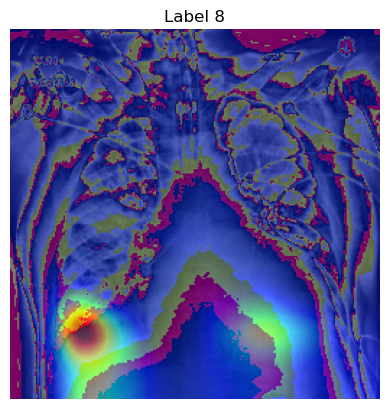

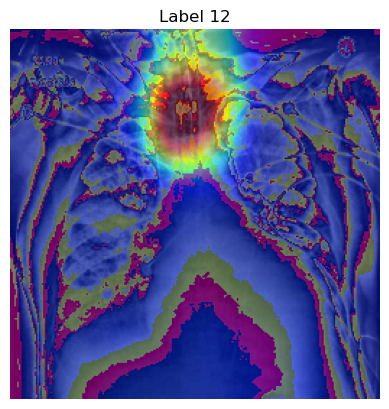

In [11]:
for i, label in enumerate(labels):
    label = label.item()
    pred = preds[i].item()
    if label == pred and label == 1.:
        _, logits = image_model(image.unsqueeze(0).to(device))
        cam = cam_extractor(i, logits)[0]
        resize = torchvision.transforms.Resize((image.shape[1], image.shape[2]), interpolation=PIL.Image.BICUBIC)
        mask = resize(cam).squeeze(0)
        #plt.imshow(mask)
        
        result = overlay_mask(to_pil_image(image), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        plt.imshow(result); plt.axis('off'); plt.title(f'Label {i}'); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


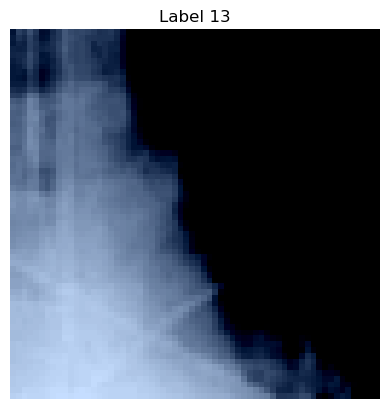

In [15]:
y, x = np.unravel_index(np.argmax(mask), mask.shape)
    
# Estrai la patch 32x32 dell'immagine originale
patch = image.numpy().transpose(1, 2, 0)
patch = patch[y:y+64, x:x+64]
patch = patch / np.max(patch)

plt.imshow(patch); plt.axis('off'); plt.title(f'Label {i}'); plt.show()

In [22]:
features, logits = image_model(torch.tensor(patch.transpose(2,0,1)).unsqueeze(0).to(device))
probs = torch.sigmoid(logits.squeeze())
preds = torch.round(probs)
print(f'Labels      -> {labels}')
print(f'Predictions -> {preds}')
print(f'Features -> {features.shape}')

Labels      -> tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
Predictions -> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       grad_fn=<RoundBackward0>)
Features -> torch.Size([1, 1024])


In [23]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)

In [25]:
for images, labels in test_loader:
    feats, logits = image_model(images.to(device))
    

[tensor([[[[-1.9809, -1.9809, -1.9809,  ..., -2.0152, -2.0152, -2.0152],
          [-1.9980, -1.9980, -1.9980,  ..., -2.0152, -2.0152, -2.0152],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0152, -2.0152, -2.0152],
          ...,
          [-2.0323, -2.0323, -2.0494,  ..., -1.8439, -1.8782, -1.9124],
          [-2.0323, -2.0323, -2.0494,  ..., -1.8439, -1.8953, -1.8953],
          [-2.0323, -2.0323, -2.0494,  ..., -1.8439, -1.8953, -1.8782]],

         [[-1.8957, -1.8957, -1.8957,  ..., -1.9307, -1.9307, -1.9307],
          [-1.9132, -1.9132, -1.9132,  ..., -1.9307, -1.9307, -1.9307],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9307, -1.9307, -1.9307],
          ...,
          [-1.9482, -1.9482, -1.9657,  ..., -1.7556, -1.7906, -1.8256],
          [-1.9482, -1.9482, -1.9657,  ..., -1.7556, -1.8081, -1.8081],
          [-1.9482, -1.9482, -1.9657,  ..., -1.7556, -1.8081, -1.7906]],

         [[-1.6650, -1.6650, -1.6650,  ..., -1.6999, -1.6999, -1.6999],
          [-1.6824, -1.6824, 

In [ ]:
def extract_patch_features(images, labels, patch_size, feat_size):
    # Get batch predictions
    features_image, logits = image_model(images.to(device))
    preds = torch.round(torch.sigmoid(logits))
    
    batch_features = torch.zeros((images.shape[0], feat_size))

    for i, image in enumerate(images):
        label = labels[i]
        pred = preds[i]
        
        # Get explanations just for correctly predicted classes
        features = torch.zeros((1, feat_size))
        for j, label_j in enumerate(label):
            label_j = label_j.item()
            pred_j = pred[j].item()
            
            if label_j == pred_j and label_j == 1.:
                # Get the model's predictions
                _, logits = image_model(image.unsqueeze(0).to(device))
                
                # Get 
                cam = cam_extractor(j, logits)[0]
                resize = torchvision.transforms.Resize((image.shape[1], image.shape[2]), interpolation=PIL.Image.BICUBIC)
                mask = resize(cam).squeeze(0)

                #result = overlay_mask(to_pil_image(image), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        
                y, x = np.unravel_index(np.argmax(mask), mask.shape)
    
                # Extract most activated patch_size x patch_size patch in the original image
                patch = image.numpy().transpose(1, 2, 0)
                patch = patch[y:y+patch_size, x:x+patch_size]
                patch = patch / np.max(patch)
                
                # Extract features from j_th patch
                features_j, _ = image_model(torch.tensor(patch.transpose(2,0,1)).unsqueeze(0).to(device))
                
                # Sum features extracted from single patches
                features = features + features_j
                
        batch_features[i] = features
    return torch.cat((batch_features, features_image), dim=1) # shape [batch_size, 1024]